### Scratch notes

NB: There are at least a few articles with contentious naming histories that don't use the old moves template. (example: https://en.wikipedia.org/wiki/Talk:Avatar)

Note on finding an article's name history (including undiscussed moves):

A trick I learned is using `rdcheck` to find pages that redirect to the article's *talk page*, as this basically seems to happen if and only if there's a move. e.g. https://dispenser.info.tm/~dispenser/cgi-bin/rdcheck.py?page=Talk:Western_African_Ebola_virus_epidemic
- cf. https://www.mediawiki.org/wiki/API:Redirects

From there, can probably get the timeline using move log? Move log with Target = [[Foo]] will show all moves *from* Foo to another name.

- Programmatic access to move log?

Interesting directory of some notable move discussions at https://en.wikipedia.org/wiki/User:Born2cycle    
    
Notes on particular examples:

**Libyan Civil War (2011)**: Relatively uncontroversial (given number of moves/RMs). Mostly a reflection of the fact that it was covering an ongoing/evolving event. A bit of nitpickery (capitalization, where to place year).

**Sarah Jane Brown**: Disambiguation is a hard problem. Gender wars.

**Genesis creation narrative**: Religious POV wars. Name candidates included:
- Creation according to Genesis (original)
- Genesis creation myth (lasted a couple months)
- Biblical Creation
- Creation story in Genesis
- Creation in Genesis
- Genesis creation story

**Western_African_Ebola_virus_epidemic**: Ongoing event, some nitpickery (West[ern] Africa[n])

**Ganges**: vs. Ganga. Not sure if this is an OFFICIALNAME thing, or something else. Need to read more. 

**Syrian Civil War**: Evolving event, nitpickery
2011 Syrian protests (created Feb 2011) -> 2011 Syrian uprising -> 2011-2012 Syrian uprising -> ...

**Islamic State of Iraq and the Levant**

**Madonna**: ptopic controversy (Madge, art term, or no ptopic)
Also some disambiguator controversy for Madge (entertainer, singer, singer/actress, Madonna Louise Ciccone)

**Chairperson**: gender wars
Move history is super-complicated because there were POV forks involved. 
Some discussion of page histories at https://en.wikipedia.org/wiki/Wikipedia:Redirects_for_discussion/Log/2019_May_20#Chairman_(version_2)
Oh, here's Chairman's old history: https://en.wikipedia.org/w/index.php?title=Talk:Chairperson/Old_history&dir=prev&action=history
Chairman:
- Created April 2003
- Made into redirect to Chairperson Jan 7 2006 (first available edit - earlier history lost?)
- Forked into standalone article June 29 2006
- Nov 2006 content merged from Chairperson?
- April 2007 merged to Chairperson, made into redirect

**Saint Peter**

**Georgia**: ptopic (state or country, or neither)

**Bangalore**: OFFICIALNAME is Bangaluru

**Republic of China (1912–1949)**: So this is basically the nation state that existed in China before the communist party took over after the civil war (and what sort of became Taiwan?). 
Big point of contention seems to be whether this should just be called "Republic of China"

**Kiev** OFFICIALNAME is Kyiv?

**Worcester**: PTOPIC issue, and nitpickery

**Usher (musician)** Created as Usher Raymond in 2003.
- question 1: is he the PTOPIC for Usher?
- question 2: which disambiguator? musician, singer, entertainer. Or Usher Raymond as natural disambig.
Lots of RMs, though mostly not very heated. (Though last one went to MRV)

**Drake (musician)** Similar to above. PTOPIC controversy, and disambiguator.

**Financial crisis of 2007-2008**: Evolving issue. Some hilarious back and forth about how far to extend the year range. 

**Yogurt** What more is there to say?
Love this: https://en.wikipedia.org/wiki/Talk:Yogurt/yogurtspellinghistory (of course it's written largely by b2c)
*NB*: seemingly a missing entry in move log for first move to Yoghurt Dec 25 2003: https://en.wikipedia.org/wiki/Special:Log?type=move&user=&page=Yoghurt&wpdate=&tagfilter=&subtype=

**Prince Harry, Duke of Sussex** Royal title nonsense. But also, was listed as 'Prince Henry of Wales' for a good 3 years, from 2006-2009. (Harry presumably won via COMMONNAME)

**Great Famine (Ireland)** vs.
- Irish Potato Famine (1845-1849) <- original name
- Irish Potato Famine
- The Great Hunger

**Star Wars (film)**: Nerd shit.

**Russian interference in the 2016 United States elections**

**Ivory Coast**: Oh boy, a lot of moves on this one (mostly short-lived back-and-forth changes)

**Orange (colour)**: Yup, it's about the 'u'. 7 RMs about the 'u'.

**Compact disc**: Mostly about capitalization. And two RMs for 'CD'.

**Ceres (dwarf planet)**: Or is it an asteroid? Or planetoid? Or "1 Ceres" (OFFICIALNAME?)?

**Illegal immigration**

**Queen Victoria**


**Avatar**: Interesting one that didn't show up on the books (no oldmoves template). Only three RMs, but seemingly highly contentious.


Roughly speaking, most pages fall into one or more of the following categories:
- Official vs. common name (especially in geographic topics)
- Topics that evolved during Wikipedia's lifetime (current events)
- Pedantry (color vs. colour, yogurt, Compact [Dd]isc)
- PTOPIC controversy (Madonna, Georgia)
- Choice of disambiguator
- Alternative names with POV implications (chairperson, illegal immigration, Genesis creation narrative)
- (rarely) Naming disputes that are actually symptoms of *content* disputes (Financial crisis of x-y)

https://matplotlib.org/gallery/lines_bars_and_markers/broken_barh.html#sphx-glr-gallery-lines-bars-and-markers-broken-barh-py as way of doing stack of boxes per event thing

In [3]:
import pandas as pd
import mwclient
import wikitextparser as wtp

wiki = mwclient.Site(('https', 'en.wikipedia.org'))

oldmoves_df = pd.read_csv('moves.csv')
titles = oldmoves_df.title.values
print(len(titles))
titles[:10]
_page_cache = {}

421


In [4]:
# Be kind, cache
def get_page(name):
    try:
        pg = _page_cache[name]
    except KeyError:
        pg = wiki.pages[name]
        _page_cache[name] = pg
    return pg

# Check redirects to talk page
# Trick found here: https://en.wikipedia.org/w/index.php?title=Wikipedia:Village_pump_(technical)&oldid=753982438#Easy_way_to_spot_user_renames.3F
# Seems to be pretty effective, though occasionally some weird stuff (e.g. compare
# https://en.wikipedia.org/w/index.php?title=Talk:Magellan-Elcano_circumnavigation&redirect=no
# to https://en.wikipedia.org/w/index.php?title=Magellan-Elcano_circumnavigation&redirect=no )
# Might want to double-check that Talk:Foo redirects to Talk:Bar AND Foo redirects to Bar?
# Another example: get_past_names('Madonna')
def get_past_names(pagename):
    """Get some of the names the article with the given title has previously been named.
    (Uses a heuristic method based on talk page redirects).
    """
    if not pagename.startswith('Talk:'):
        pagename = 'Talk:'+pagename
    res = wiki.api('query', prop='redirects', titles=pagename)
    thing = list(res['query']['pages'].values())[0]
    try:
        reds = thing['redirects']
    except KeyError:
        # No redirects
        reds = []
    res = [
        # Strip talk prefix
        red['title'][len('Talk:'):] for red in reds
    ] + [pagename[len('Talk:'):]]
    # HACK - some complicated hydra-like situation going on with this one involving copy-paste moves
    if pagename == 'Talk:Chairperson':
        res.append('Chair (official)')
    return res

def parse_move_event(evt):
    #assert evt['action'] == 'move', evt
    return {
        'from': evt['title'],
        'to': evt['params']['target_title'],
        'time': evt['timestamp'],
        'comment': evt.get('comment', '???'),
        'action': evt['action'],
    }

def get_first_name(canon, moves):
    canon_i = None
    for i, mv in enumerate(moves):
        if mv['from'] == canon:
            return canon
        if mv['to'] == canon:
            curr = mv['from']
            if i == 0:
                return curr
            for prev in moves[i-1::-1]:
                if prev['to'] == curr:
                    # This is far more indentation than I'm comfortable with.
                    curr = prev['from']
            return curr
    return canon
    

def get_creation_evt(canon, moves):
    """Create a dummy pseudo-move event corresponding to article creation to put at start of history"""
    pg = get_page(canon)
    revs = pg.revisions(dir='newer', limit=1)
    first = revs.next()
    firstname = get_first_name(canon, moves)
    return {
        'from': None,
        'to': firstname,
        'time': first['timestamp'],
        'comment': first['comment'],
        'action': 'create',
    }


# TODO: Would be nice to have a function that combines these events with RMs
def get_moves(canon, clean=True):
    """
    TODO: Maybe do some post-processing step to remove any components from the graph which
    are not connected to the canon name (helps repair issues introduced by wonky talk redirects,
    cf. comment on get_page_names)
    Or, equivalently(?), if mvs[i][to] != mvs[i+1][from], then remove mvs[i+1]
    """
    # because of reasons
    canon = canon.replace('_', ' ')
    if canon.startswith('Talk:'):
        canon = canon[5:]
    names = get_past_names(canon)
    moves = []
    seen = set()
    while names and len(seen) < 100:
        name = names.pop()
        # This gets move events FROM title
        evts = wiki.logevents(type='move', title=name)
        for evt in evts:
            mv = parse_move_event(evt)
            moves.append(mv)
            dest = mv['to']
            if dest not in seen and dest not in names:
                names.append(dest)
        seen.add(name)
            
    moves.sort(key=lambda evt: evt['time'])
    # add a dummy event at beginning corresponding to article creation (from=None)
    genesis = get_creation_evt(canon, moves)
    moves.insert(0, genesis)
    
    # Look for moves not connected to the 'mainline'. If clean=True, exclude them from the output.
    # Otherwise, include them but set 'flag' to 'x'
    cm = [moves[0]]
    lastgood = cm[0]
    for mv in moves[1:]:
        if mv['from'] == lastgood['to']:
            cm.append(mv)
            lastgood = mv
        elif not clean:
            mv['flag'] = 'x'
            cm.append(mv)
    cut = len(moves) - len(cm)
    #if cut: print("Warning: dropped {} moves not connected to mainline".format(cut))
    moves = cm
            
    return moves

#title = 'Talk:Sarah Jane Brown'
#pasta = get_past_names(title)
#print(pasta)
#mvs = get_moves(title)

In [7]:
from tabulate import tabulate
import datetime
import time

def pprinted_history(name):
    mvs = get_moves(name)
    rows = []
    prev_dt = None
    for mv in mvs:
        ts = mv['time']
        dt = datetime.datetime.fromtimestamp(time.mktime(ts))
        if prev_dt:
            delta = dt - prev_dt
            diffstr = '+{}d'.format(delta.days)
        else:
            diffstr = ''
        when = '{}/{}/{} {}:{} ({})'.format(ts.tm_year, ts.tm_mon, ts.tm_mday,
                                       ts.tm_hour, ts.tm_min,
                                            diffstr,
                                      )
        row = [mv['from'], RARROW, mv['to'], when, mv.get('flag', '')]
        rows.append(row)
        prev_dt = dt

    return tabulate(rows)

def pprint_history(name, clean=True):
    mvs = get_moves(name, clean=clean)
    rows = []
    prev_dt = None
    for mv in mvs:
        ts = mv['time']
        dt = datetime.datetime.fromtimestamp(time.mktime(ts))
        if prev_dt:
            delta = dt - prev_dt
            diffstr = '+{}d'.format(delta.days)
        else:
            diffstr = ''
        when = '{}/{}/{} {}:{} ({})'.format(ts.tm_year, ts.tm_mon, ts.tm_mday,
                                       ts.tm_hour, ts.tm_min,
                                            diffstr,
                                      )
        row = [mv['from'], RARROW, mv['to'], when, mv.get('flag', '')]
        rows.append(row)
        prev_dt = dt

    print(
        tabulate(rows),
    )
    return mvs
    
#mvs = pprint_history('Yogurt')
#mvs

In [437]:
pprint_history('Ivory Coast', clean=False);

---------------------------  -  ---------------------------  -------------------------  -
                             →  Côte d'Ivoire                2001/10/31 22:53 ()
Côte d'Ivoire                →  Ivory Coast                  2005/11/11 16:42 (+1471d)
Ivory Coast                  →  Côte d'Ivoire                2005/11/11 17:22 (+0d)
Côte d'Ivoire                →  Ivory Coast                  2005/11/11 17:31 (+0d)
Ivory Coast                  →  Côte d'Ivoire                2005/11/11 17:33 (+0d)
Côte d'Ivoire                →  Ivory Coast                  2005/11/14 15:55 (+2d)
Ivory Coast                  →  Côte d'Ivoire                2005/11/14 16:8 (+0d)
Côte d'Ivoire                →  Ivory Coast                  2005/11/17 2:37 (+2d)
Ivory Coast                  →  Côte d'Ivoire                2005/11/17 6:49 (+0d)
Côte d'Ivoire                →  Ivory Coast                  2006/4/7 17:30 (+141d)
Ivory Coast                  →  Côte d'Ivoire                2006/4/7 17:

[{'action': 'create',
  'comment': '*',
  'from': None,
  'time': time.struct_time(tm_year=2001, tm_mon=10, tm_mday=31, tm_hour=22, tm_min=53, tm_sec=47, tm_wday=2, tm_yday=304, tm_isdst=-1),
  'to': "Côte d'Ivoire"},
 {'action': 'move',
  'comment': 'most common version of name in use, in English',
  'from': "Côte d'Ivoire",
  'time': time.struct_time(tm_year=2005, tm_mon=11, tm_mday=11, tm_hour=16, tm_min=42, tm_sec=24, tm_wday=4, tm_yday=315, tm_isdst=-1),
  'to': 'Ivory Coast'},
 {'action': 'move_redir',
  'comment': '',
  'from': 'Ivory Coast',
  'time': time.struct_time(tm_year=2005, tm_mon=11, tm_mday=11, tm_hour=17, tm_min=22, tm_sec=43, tm_wday=4, tm_yday=315, tm_isdst=-1),
  'to': "Côte d'Ivoire"},
 {'action': 'move_redir',
  'comment': 'Wikipedia naming policy - please discuss before undoing again',
  'from': "Côte d'Ivoire",
  'time': time.struct_time(tm_year=2005, tm_mon=11, tm_mday=11, tm_hour=17, tm_min=31, tm_sec=52, tm_wday=4, tm_yday=315, tm_isdst=-1),
  'to': 'Ivory 

In [8]:
import re

RARROW = '→'

class NoOldMovesTemplateException(Exception):
    pass

class RM(object):
    
    def __init__(self, name):
        self.name = name
        self.om = get_oldmoves(name)
        templates = wtp.parse(self.om).templates
        # Nvm, can have templates inside the oldmoves template and that's fine. Pretty sure oldmove is always first.
        #assert len(templates) == 1, templates
        self.parsed = templates[0]
    
    @property
    def lists(self):
        return self.parsed['list'] + '\n' + self.parsed.get('oldlist', '')
    
    @property
    def all_text(self):
        # Hack
        return '\n' + '\n'.join([arg.value for arg in self.parsed.arguments])
    
    @property
    def titles(self):
        return [arg.value.strip() for arg in self.parsed.arguments if arg.name.startswith('title')]
        
    def as_row(self):
        return dict(
            name=self.name,
            bullets=self.all_text.count('\n*'),
            arrows=self.all_text.count(RARROW) + self.all_text.count('->') + self.all_text.count('&rarr;'),
            ntitles=len(self.titles),
            titles='↔'.join(self.titles),
        )

# hall of hacks
special_cases = {
    'Talk:Georgia_(country)': 'Template:GeorgiaRMArchive',
    'Talk:Georgia_(U.S._state)': 'Template:GeorgiaRMArchive',
    'Talk:Georgia': 'Template:GeorgiaRMArchive',
    
    'Talk:Madonna': 'Template:MadonnaRMArchive',
    'Talk:Madonna_(art)': 'Template:MadonnaRMArchive',
    'Talk:Madonna_(entertainer)': 'Template:MadonnaRMArchive',
    
    'Talk:Ubuntu': 'Template:UbuntuRMArchive',
    'Talk:Ubuntu_(disambiguation)': 'Template:UbuntuRMArchive',
    
    # Just transcludes same template Talk:List_of_Doctor_Who_episodes_(2005%E2%80%93present)
    'Talk:List_of_Doctor_Who_episodes_(1963–1989)': None,
    
    # dunno how this got munged
    'Talk:\\Heroes\\"_(David_Bowie_song)"': 'Talk:"Heroes" (David Bowie song)'
}

def get_oldmoves(pagename):
    if not pagename.startswith('Talk:'):
        pagename = 'Talk:'+pagename
    if pagename in special_cases:
        pagename = special_cases[pagename]
        if pagename is None:
            # sure why not
            raise NoOldMovesTemplateException
    pg = get_page(pagename)
    text = pg.text()
    # Old moves | oldmoves | old RM multi | oldrmmulti
    try:
        x = re.search('{{old ?(moves|rm)', text, flags=re.IGNORECASE)
        a = x.start()
    except:
        raise NoOldMovesTemplateException
    # this is silly
    i = x.end()
    stack = 1
    while stack > 0:
        if text[i:i+2] == '{{':
            stack += 1
        if text[i:i+2] == '}}':
            stack -= 1
        i += 1
    content = text[a:i+1]
    return content


In [26]:
"""
Heuristically trying to grab info about individual RMs from oldmoves templates.
"""
import dateparser

[
    ('Yogurt', (2002, 12, 11), 'C'),
    ('Yoghurt', (2003, 12, 25), 'M'),
    ('Yogurt', (2005, 5, 12), 'RM/NC'),
    ('Yogurt', (2006, 10, 10), 'RM/Y'),
    ('Yoghurt', (2006, 10, 26), 'RM/Y'),
    ('Yogurt', (2007, 5, 21), 'RM/NC'),
    ('Yogurt', (2009, 6, 21), 'RM/NC'),
    ('Yogurt', (2009, 7, 6), 'RM/NC'),
    ('Yogurt', (2011, 10, 27), 'RM/NC'),
    ('Yogurt', (2011, 12, 10), 'RM/Y'),
    # https://en.wikipedia.org/wiki/Talk:Yogurt/Archive_7#Requested_move_No.?,_13_April_2014
    ('Yogurt / Yoghurt', (2013, 4, 13), 'RM/N'),
]

def parse_rm(line):
    """Want to extract (if possible):
    - date
    - proposed name
    - outcome
    """
    orig = line
    line = line.lower()
    if 'no consensus' in line:
        outcome = 'NC'
    elif re.search('not? move', line):
        outcome = 'N'
    elif re.search("'''move", line):
        outcome = 'Y'
    elif 'withdrawn' in line or 'pulled' in line or 'closed' in line:
        outcome = 'X'
    else:
        outcome = '?'
    
    i_rarrow = None
    if RARROW in line:
        i_rarrow = line.index(RARROW)
    elif '->' in line:
        i_rarrow = line.index('->') + 1
    elif '&rarr;' in line:
        i_rarrow = line.index('&rarr;') + len('&rarr;')-1
    if i_rarrow is None:
        name = '?'
    else:
        end = line.find(',', i_rarrow)
        if end == -1:
            end = line.find('}}', i_rarrow)
        if end == -1:
            end = line.find(']]', i_rarrow)
        name = orig[i_rarrow+1:end]
        name = name.strip(' {}[]')
        if '|' in name:
            name = name[name.find('|')+1:]
    
    match = re.search(r'\d\d? [A-Z][a-z]+,? 20\d\d', orig)
    if not match:
        match = re.search(r'[A-Z][a-z]+ \d\d?,? 20\d\d', orig)
    if not match:
        date = '?'
    else:
        date = orig[match.start():match.end()]
        date = dateparser.parse(date).date()
    return [name, date, outcome]

def parse_rms(om_str):
    # This is going to be very heuristical
    rms = []
    for line in om_str.split('\n'):
        if not (line.startswith('#') or line.startswith('*')):
            continue
        rm = parse_rm(line)
        rms.append(rm)
    return rms

def get_rms(name):
    om = get_oldmoves(name)
    return parse_rms(om)

In [515]:
#get_rms('Orange (colour)')

[['Orange (color)', '?', '?'],
 ['Orange (colour)', '?', '?'],
 ['Orange (color)', '?', '?'],
 ['Orange (color)', '?', '?'],
 ['Orange (color)', '?', '?'],
 ['Orange', '?', '?'],
 ['Orange_(color)', '?', '?']]

In [516]:
# Populated basically by copy-pasting result of get_rms with manual tweaks, 
# mostly to add info that was unable to be parsed from the template entries (rendered as '?' in get_rms output).
fincri = 'Financial crisis of 2007–2008'
RMs = {
    
    'Orange (colour)':
    [['Orange (color)', datetime.date(2002, 8, 15), 'Y'],
 ['Orange (colour)', datetime.date(2004, 3, 15), 'Y'],
 ['Orange (color)', datetime.date(2005, 6, 15), 'N'],
 ['Orange (color)', datetime.date(2005, 10, 15), 'N'],
 ['Orange (color)', datetime.date(2006, 4, 15), 'N'],
 ['Orange', datetime.date(2006, 4, 15), 'N'],
 ['Orange (color)', datetime.date(2007, 11, 15), 'N']],
    
    'Drake (musician)':
    [['Drake (entertainer)', datetime.date(2010, 7, 8), 'Y'],
 ['Drake (rapper)', datetime.date(2013, 3, 10), 'NC'],
 ['Drake', datetime.date(2013, 6, 29), 'Y'],
 ['Drake (singer)', datetime.date(2016, 6, 11), 'NC'],
 ['Drake (musician)', datetime.date(2016, 6, 21), 'Y'],
 ['Drake', datetime.date(2017, 7, 17), 'NC'],
 ['Drake', datetime.date(2017, 8, 26), 'NC'],
 ['Drake', datetime.date(2019, 3, 23), 'NC'],
 ['Drake (vocalist)', datetime.date(2019, 5, 11), 'NC']],
    
    'Russian interference in the 2016 United States elections':
    [['Russian interference in the 2016 United States elections',
  datetime.date(2016, 12, 21),
  'N'],
 #['Russian interference in the 2016 United States elections', datetime.date(2017, 1, 7), '?'],
     # ^ MRV
 ['Intelligence reports of Russian interference in the 2016 United States elections',
  datetime.date(2016, 12, 29),
  'N'],
 ['Grizzly Steppe', datetime.date(2016, 12, 30), 'N'],
 ['Allegations of Russian interference in the 2016 United States elections',
  datetime.date(2017, 1, 7),
  'NC'],
 ['Alleged 2016 United States election interference by Russia',
  datetime.date(2017, 2, 4),
  'NC'],
     ['Russian interference in the 2016 United States elections', datetime.date(2017, 2, 17), 'Y'],
    ],
    
    'Ivory Coast':
    [['Ivory Coast', datetime.date(2005, 11, 11), 'NC'],
 ['Ivory Coast', datetime.date(2007, 1, 8), 'NC'],
 ['Ivory Coast', datetime.date(2010, 6, 21), 'NC'],
 ['Ivory Coast', datetime.date(2010, 7, 11), 'NC'],
 ['Ivory Coast', datetime.date(2011, 6, 19), 'NC'],
 ['Ivory Coast', datetime.date(2012, 6, 12), 'Y'],
 #['Ivory Coast', datetime.date(2012, 7, 10), 'NC'],
     # ^ MRV
    ],
    
    'Chairperson':
    [['Chairperson', datetime.date(2006, 1, 7), 'Y'],
     ['Chair (official)', datetime.date(2007, 4, 12), 'MV'],
     # ^ Added manually. cf. https://en.wikipedia.org/wiki/Talk:Chairman#Merge_to_suggestion
 ['Chairman', datetime.date(2008, 11, 4), 'Y'],
 #['Chair (officer)', datetime.date(2009, 9, 15), 'Y'],
 #['Chairman', datetime.date(2009, 9, 15), 'Y'],
     # Hm, above are actually a flipflop. Should maybe ignore. Or could code as failed RM. 
 [
     #'Chair (position) or Chairperson', 
     'Chair (position)',
  datetime.date(2015, 2, 17), 'N'],
 ['Chair (officer)', datetime.date(2019, 3, 22), 'NC'],
 #['?', datetime.date(2019, 4, 17), '?'],
     # ^ Move review
 ['Chairperson', datetime.date(2019, 4, 17), 'N'],
 ['Chairperson', datetime.date(2019, 5, 8), 'Y'],
 #['?', datetime.date(2019, 5, 16), '?'],
     # ^ Move review
 ['Chair (presiding officer)', datetime.date(2019, 5, 16), 'N']],
    
    'Star Wars (film)':
    [['Star Wars (film)', datetime.date(2009, 7, 29), 'N'],
 [
     #'Star Wars (1977 film)]] or [[Star Wars: A New Hope]] or [[Star Wars (film)',
     'Star Wars (film)',
  datetime.date(2014, 1, 7),
  'Y'],
 ['Star Wars Episode IV: A New Hope', datetime.date(2014, 10, 13), 'N'],
 ['Star Wars Episode IV: A New Hope', datetime.date(2015, 2, 8), 'N'],
 #['?', '?', 'X'],
     # ^ Move review
 ['Star Wars Episode IV: A New Hope', datetime.date(2015, 3, 17), 'X'],
     # ^ Closed as disruptive, spawned a 6mo moratorium
 ['Star Wars', datetime.date(2015, 12, 5), 'NC'],
 ['Star Wars: Episode IV – A New Hope', datetime.date(2016, 6, 6), 'N'],
     # ^ WP:SNOW
 ],
    
    'Compact disc':
    [['Compact disc', datetime.date(2007, 9, 15), 'NC'],
     # ^ This went on for a surprisingly long time. Like til 2009??
 ['compact disk', datetime.date(2009, 4, 14), 'N'],
 ['CD', datetime.date(2009, 6, 5), 'N'],
 ['Compact disc', datetime.date(2010, 2, 14), 'N'],
     # ^ Moved then reverted within a day
 ['Compact disc', datetime.date(2013, 3, 2), 'Y'],
 ['CD', datetime.date(2013, 3, 30), 'N'],
 ['Compact Disc', datetime.date(2013, 8, 12), 'N']],
    
    fincri:
    [['Financial_crisis_(2007–present)', datetime.date(2011, 1, 7), 'Y'],
 ['Late-2000s financial crisis', datetime.date(2011, 3, 1), 'Y'],
 ['Financial crisis (2007–present)', datetime.date(2011, 6, 6), 'NC'],
 ['Global Financial Crisis', datetime.date(2012, 5, 8), 'N'],
 ['2007–present global financial crisis', datetime.date(2012, 7, 10), 'N'],
 ['Global financial crisis of 2008', datetime.date(2012, 7, 30), 'NC'],
 #['Global financial crisis of 2008', datetime.date(2012, 8, 19), '?'],
     # ^ Move review for prior RM
 ['Financial crisis of 2007–2008', datetime.date(2012, 10, 9), 'Y']],
    
    'Sarah Jane Brown': 
    [['Sarah Brown', datetime.date(2007, 6, 4), 'NC'],
 ['Sarah Brown', datetime.date(2009, 11, 9), 'N'],
 ['Sarah Brown (born 1963)', datetime.date(2010, 2, 15), 'Y'],
 ['Sarah Brown (public relations)', datetime.date(2010, 4, 15), 'NC'],
 ['Sarah Brown (businesswoman)', datetime.date(2013, 4, 14), 'NC'],
 ['Sarah Jane Brown', datetime.date(2013, 6, 23), 'Y'],
 #['Sarah Jane Brown', datetime.date(2013, 7, 9), '?'],
                         # ^ Move review
 ['Sarah Brown', datetime.date(2014, 4, 24), 'N'],
 ['Sarah Brown (wife of Gordon Brown)', datetime.date(2014, 4, 25), 'X'],
 ['Sarah Brown', datetime.date(2014, 10, 11), 'NC'],
 ['TBD', datetime.date(2014, 10, 24), 'N'],
                         # ^ Drop above for simplicity?
 # TODO: Might be worth noting a 6-month moratorium that passed 25 October 2014
 # https://en.wikipedia.org/wiki/Talk:Sarah_Jane_Brown/Archive_7#Propose_moratorium_on_pagemove_discussion
 ['Sarah Brown (businesswoman and wife of Gordon Brown)',
  datetime.date(2015, 5, 19),
  'N'],
 ['Sarah Brown (charity director)', datetime.date(2016, 12, 9), 'N'],
 ['Sarah Brown (education campaigner)', datetime.date(2018, 2, 6), 'X'],
 ['Sarah Brown (wife of Gordon Brown)', datetime.date(2018, 2, 7), 'X'],
 ['TBD', datetime.date(2018, 2, 28), 'NC']],
    
    'Genesis creation narrative': 
    [['Genesis creation myth', datetime.date(2010, 1, 27), 'Y'],
 ['Creation according to Genesis', datetime.date(2010, 2, 16), 'NC'],
 ['Creation according to Genesis', datetime.date(2010, 3, 25), 'NC'],
 ['Biblical Creation', datetime.date(2010, 4, 4), 'NC'],
 ['Genesis creation narrative', datetime.date(2010, 4, 20), 'Y'],
 ['Genesis creation myth', datetime.date(2012, 3, 4), 'NC'],
 ['Creation story in Genesis',
  datetime.date(2012, 3, 4),
  'NC'],
 ['Genesis creation myth', datetime.date(2012, 9, 28), 'NC'],
 ['Creation in Genesis', datetime.date(2013, 2, 1), 'N'],
 ['Genesis creation myth', datetime.date(2013, 2, 4), 'N'],
 ['Genesis creation myth', datetime.date(2014, 1, 22), 'NC'],
 ['Genesis creation myth', datetime.date(2014, 4, 23), 'NC'],
 #['?', datetime.date(2014, 5, 1), '?'],
                                   # ^ moratorium
 ['Genesis creation myth', datetime.date(2016, 1, 22), 'N'],
 #['?', datetime.date(2016, 2, 22), '?'],
                                   # ^ moratorium
 ['Genesis creation story', datetime.date(2017, 2, 22), 'X']],
    
    'Yogurt':
    [['Yogurt', datetime.date(2005, 5, 12), 'NC'],
 ['Yogurt', datetime.date(2006, 10, 10), 'Y'],
 #['Yogurt', datetime.date(2006, 10, 26), 'NC'],
 ['Yoghurt', datetime.date(2006, 10, 26), 'Y'],
 # Convenient fiction for complicate situation
 ['Yogurt', datetime.date(2007, 5, 21), 'NC'],
 ['Yogurt', datetime.date(2009, 6, 21), 'N'],
 ['Yogurt', datetime.date(2009, 7, 6), 'NC'],
 ['Yogurt', datetime.date(2011, 10, 27), 'NC'],
 ['Yogurt', datetime.date(2011, 12, 10), 'Y']
     # NB: Also a sort of spurious RM in 2014 not listed in oldmoves template
    ],
    
}

In [61]:
def _filter_ephemeral_moves(moves):
    filtered = []
    prev = moves[0]
    for mv in moves[1:]:
        dt1 = datetime.datetime.fromtimestamp(time.mktime(prev['time']))
        dt2 = datetime.datetime.fromtimestamp(time.mktime(mv['time']))
        delta = dt2 - dt1
        if delta.days > 0:
            filtered.append(prev)
        prev = mv
    filtered.append(moves[-1])
    return filtered

def _collapse_moves(moves):
    """Combine runs of moves with the same target into one move event."""
    res = [moves[0]]
    prev = moves[0]
    for mv in moves[1:]:
        # Allow dict input (from get_moves) or 3-list input
        if isinstance(mv, dict):
            a, b = mv['to'], prev['to']
        else:
            a, b = mv[0], prev[0]
        if a == b:
            continue
        else:
            res.append(mv)
            prev = mv
    return res

def munged_moves(name, filter=1):
    moves = get_moves(name, clean=True)
    if filter:
        moves = _filter_ephemeral_moves(moves)
        moves = _collapse_moves(moves)
    
    res = []
    for mv in moves:
        dt = datetime.datetime.fromtimestamp(time.mktime(mv['time']))
        action = 'C' if mv['action'] == 'create' else 'MV'
        row = [mv['to'], dt.date(), action]
        res.append(row)
    return res

#munged_moves('Yogurt')

In [568]:
import pprint

def _collapse_events(moves):
    """Combine redundant events."""
    res = [moves[0]]
    prev = moves[0]
    for mv in moves[1:]:
        a, b = mv[0], prev[0]
        evts = {mv[2], prev[2]}
        dontskips = {'NC', 'N', 'X'}
        if a == b and not evts.intersection(dontskips):
            if 'Y' in evts:
                prev[2] = 'Y'
            continue
        else:
            res.append(mv)
            prev = mv
    return res

def merged_history(name):
    rms = RMs[name]
    moves = munged_moves(name)
    hist = rms + moves
    hist.sort(key=lambda x:x[1])
    hist = _collapse_events(hist)
    return hist

def tweaks(hist):
    yog = hist['Yogurt']
    # Actual title at creation
    yog[0][0] = 'Yogurt'
    # Move not recorded in move log (too old?)
    # https://en.wikipedia.org/wiki/Talk:Yogurt/yogurtspellinghistory#December_25,_2003:_%22yogurt%22_changed_to_%22yoghurt%22_first_time
    yog.insert(1, 
               ['Yoghurt', datetime.date(2003, 12, 25), 'MV']
              )
    
    ficri = hist['Financial crisis of 2007–2008']
    # Dupe of ficri[8] not recognized as such because it uses underscores instead of spaces
    assert '_' in ficri[7][0], ficri[7]
    del ficri[7]
    
    ch = hist['Chairperson']
    # Creation date incorrect because of complicated fork situation
    ch[0][1] = datetime.date(2003, 4, 15)
    
    cd = hist['Compact disc']
    # https://en.wikipedia.org/wiki/Talk:Compact_disc/Archive_2#Name_shouldn.27t_be_capitalized
    # RM Started 2007 09 15 advocating 'Compact disc'
    # Didn't really go anywhere. Eventually finally closed 13 Dec 2009
    #['Compact disc', datetime.date(2007, 8, 18), 'MV'], # i=4-6
    #['Compact disc', datetime.date(2007, 9, 15), 'NC'],
    #['Compact Disc', datetime.date(2007, 9, 15), 'MV'],
    # So seems like timeline is. 
    #   8/18: bold move to Compact disc. 
    #   9/15: move reverted *and* RM opened for Compact disc (which didn't go anywhere)
    # So elide the NC RM in the middle
    assert cd[5][2] == 'NC', cd[5]
    assert cd[5][0] == 'Compact disc', cd[5]
    del cd[5]
    

hists = {name: merged_history(name) for name in RMs.keys()}
tweaks(hists)
pprint.pprint(hists, width=120)

{'Chairperson': [['Chairman', datetime.date(2003, 4, 15), 'C'],
                 ['Chairperson', datetime.date(2006, 1, 7), 'Y'],
                 ['Chair (official)', datetime.date(2007, 4, 12), 'MV'],
                 ['Chairman', datetime.date(2008, 11, 4), 'Y'],
                 ['Chair (officer)', datetime.date(2009, 9, 15), 'Y'],
                 ['Chairman', datetime.date(2009, 9, 15), 'Y'],
                 ['Chair (position)', datetime.date(2015, 2, 17), 'N'],
                 ['Chair (officer)', datetime.date(2019, 3, 22), 'NC'],
                 ['Chairperson', datetime.date(2019, 4, 17), 'N'],
                 ['Chairperson', datetime.date(2019, 5, 8), 'Y'],
                 ['Chair (presiding officer)', datetime.date(2019, 5, 16), 'N']],
 'Compact disc': [['Compact disc', datetime.date(2001, 9, 18), 'C'],
                  ['Compact Disc', datetime.date(2006, 6, 14), 'MV'],
                  ['Compact disc', datetime.date(2007, 1, 25), 'MV'],
                  ['Compact Di

In [441]:

#pprint_history('Ivory Coast', clean=1);

# Viz

- Stacked 'outer' rects corresponding to each (enduring) name change
- Labelled at top with name
- Contain any failed RMs that happened during their tenure
- Try to draw outer rects proportional to duration, but make sure there's room for all the inner rects. 
- Timeline axis running down side per subplot? But might look a little weird with stretching of time (to accomodate tightly packed events)
    - a) use major/minor ticks to make the stretches more apparent/intuitive?
    - b) label year/mo of each event, but don't do any regular ticks <- kinda leaning towards this one
    - maybe even only label dates of successful renames?
- Unique colors per name?

In [67]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

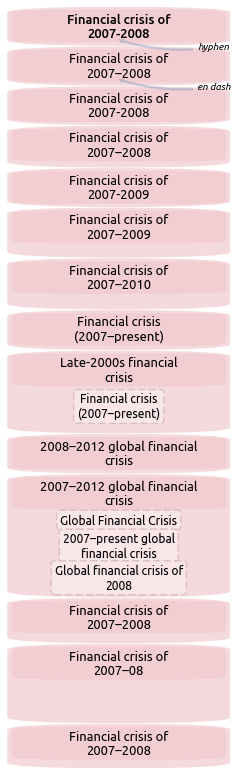

In [801]:
import textwrap
import seaborn as sns
from collections import Counter
import random

def _divide_eras(evts):
    eras = []
    era = [evts[0]]
    for evt in evts[1:]:
        if evt[2] in {'Y', 'MV'}:
            eras.append(era)
            era = [evt]
        else:
            era.append(evt)
    eras.append(era)
    return eras

def wrap_label(label, inner=False):
    w = 26
    if inner and 0:
        w = int(3/4 * w)
    return '\n'.join(textwrap.wrap(label, width=w))
    
def make_colormapping(evts):
    thresh = 0
    if thresh:
        names = [evt[0] for evt in evts]
        counts = Counter(names)
        map = {}
        todo = []
        for name, count in counts.items():
            if count == 1:
                map[name] = '0.65'
            else:
                todo.append(name)
        n = len(todo)

        cm = plt.cm.Set2
        colors = cm.colors
        if n > len(colors):
            colors = plt.cm.tab20.colors

        assert n <= len(colors), 'Too many names: {} < {}\nNames={}'.format(n, len(colors), names)
        colors = [sns.desaturate(c, .35) for c in colors]
        random.shuffle(colors)
        for i, name in enumerate(todo):
            map[name] = colors[i]
        #return dict(zip(list(names), colors))
        return map
    else:
        names = set([evt[0] for evt in evts])
        n = len(names)
        cm = plt.cm.Set2
        colors = cm.colors
        if n > len(colors):
            colors = plt.cm.tab20.colors

        assert n <= len(colors), 'Too many names: {} < {}\nNames={}'.format(n, len(colors), names)
        colors = [sns.desaturate(c, .35) for c in colors]
        return dict(zip(list(names), colors))

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def fmt_date_annot(month, year):
    return '\n({})'.format(year)
    
def plot_hist(fig, ax, evts, debug=False, natural_axes=False, colorize=True, annot=False,
             spines=False, basecolor=None, ticks=False,
              label_lightness=.8, bg_lightness=.6, inner_lightness=.4,
             ):
    """
    debug: print a bunch of debug messages while plotting, and add some debug cruft to the plot itself
    natural_axes: keep axes visible and use default tick marks/labels (in data units)
    colorize: assign a unique color per distinct name
    annot: special double-wide plot with explanatory annotations
    spines: whether to make axis lines visible
    basecolor: use this as a basis for box colors
    """
    # Abandon hope all ye who enter here
    cmap = make_colormapping(evts)
    fig.set_facecolor('white')
    def LOG(s):
        if debug:
            print(s)
    eras = _divide_eras(evts)
    # NB: Treat 0 as top/start. Invert y axis at the end.
    start, end = evts[0][1], evts[-1][1]
    dur = end - start
    hscale = lambda dur: dur.days/365
    annot_offset = 1 if annot else 0
    outer_x0 = 0 + annot_offset
    outer_w = 1
    outer_x1 = outer_x0 + outer_w
    inner_x0 = .2 + annot_offset
    inner_w = outer_w - (inner_x0 * 2)
    box_hpadding = .05
    inter_outer_margin = .1 # .3
    text_kwargs = dict(fontfamily='Ubuntu')
    outer_text_kwargs = text_kwargs.copy()
    outer_text_kwargs.update(dict(
        fontsize=13,
    ))
    inner_text_kwargs = text_kwargs.copy()
    inner_text_kwargs.update(dict(
        fontsize=12,
    ))
    annot_kwargs = text_kwargs.copy()
    annot_kwargs.update(dict(
        arrowprops=dict(arrowstyle='->'),
                    ha='center',
        fontsize=14,
        va='top',
        #fontstyle='oblique',
    ))
    label_alpha = outer_alpha = inner_alpha = .4
    label_alpha = .2
    
    def calc_boxh(txt, inner=False):
        # 1 line of text at larger font size should give a result around 1
        label = wrap_label(txt, inner)
        nlines = label.count('\n') + 1
        kwargs = inner_text_kwargs if inner else outer_text_kwargs
        fs = kwargs['fontsize']
        pad = .1 * 2 * (.95 if inner else 1)
        lineh = fs / 10
        res = lineh * nlines + pad
        if not inner: # XXX: Hack to account for yshrink
            res += .25 * 2
        return res
    
    # y-axis of the top of the next outer rect
    offset = 0
    # Keep track of the y-positions where eras begin. We'll put ticks/labels there (with dates)
    era_ys = []
    era_labels = []
    firstannot = False
    # TODO: Subroutines? This code is loooong and hard to read.
    for i, era in enumerate(eras):
        LOG('Era={}'.format(i))
        if i == len(eras) - 1:
            # If this is the last era, treat it as lasting until the last event 
            # plus a buffer of at least a few months (this is conservative - most of
            # these rename wars have been settled on the current title for years)
            dur = (era[-1][1] - era[0][1]) + datetime.timedelta(days=30*6)
        else:
            # Time between start of this era and start of next era
            dur = eras[i+1][0][1] - era[0][1]
        # TODO: Estimate box heights *taking into account wrapping*?
        # ...or maybe just steal the space where we can get it and be procrustean about outer h's
        era_label = wrap_label(era[0][0]
                               + (' [i={}]'.format(i) if debug else '')
                              )
        labelh = calc_boxh(era_label, 0)
        inner_hs = [calc_boxh(evt[0], 1) for evt in era[1:]]
        outer_h = labelh + sum(inner_hs) + box_hpadding*(len(era)-1) + hscale(dur)
        outer_color = basecolor or (cmap[era[0][0]] if colorize else 
            #plt.cm.Pastel1.colors[1]
            '#bbaa77')
        # Outer rect for this era
        # Bit of a hack
        xshrink = .02
        yshrink = .25
        outer = patches.FancyBboxPatch(
            (outer_x0, offset),
            outer_w,
            outer_h,
            fc=lighten_color(outer_color, bg_lightness),
            #alpha=outer_alpha,
            ec='black',
            lw=0, ls='-.',
            boxstyle='round,pad=0., rounding_size=0.5',
        )
        ax.add_patch(outer)
        LOG("Outer box drawn at ({}, {}) with h={}".format(
            outer_x0, offset, outer_h,
        ))
        # Label at top of rect showing the governing name during this era
        labelbox = patches.FancyBboxPatch(
            (outer_x0 + xshrink, offset+yshrink),
            outer_w - 2*xshrink,
            labelh-yshrink*2,
            fc=lighten_color(outer_color, label_lightness),
            #alpha=label_alpha,
            ec='violet', lw=0, ls='-',
            boxstyle='round,pad=0., rounding_size=0.25',
        )
        ax.add_patch(labelbox)
        LOG('Labelbox at {}, {} with h={}'.format(outer_x0, offset, labelh))
        era_ys.append(offset + labelh/2)
        dat = era[0][1]
        era_labels.append('{}/{}'.format(dat.year, dat.month))
        ax.text(annot_offset + .5, offset + labelh/2, era_label,
                ha='center',
                va='center',
                fontweight='semibold' if i == 0 else 'normal',
                **outer_text_kwargs
               )
        LOG('Label text {!r} placed at y={:.2f}'.format(era_label, offset))
        
        ## Add inner rects for failed rename proposals during this era
        # The (top) y coord for the next inner box/label.
        inner_offset = offset + labelh + box_hpadding
        prev = era[0]
        for evt, innerh in zip(era[1:], inner_hs):
            # Time elapsed between this event and the last one
            delta = evt[1] - prev[1]
            # Translated into data units
            delay = hscale(delta)
            y = inner_offset+delay
            inner_color = basecolor or (cmap[evt[0]] if colorize else plt.cm.Pastel1.colors[0])
            txt = ax.text(annot_offset + .5, y, 
                    wrap_label(evt[0], inner=True), 
                    ha='center',
                    va='top',
                    bbox=dict(
                        boxstyle='round',
                        facecolor=lighten_color(inner_color, inner_lightness),
                        #alpha=inner_alpha,
                        lw=1.5, ls=(0, (5, 2)), 
                        ec=sns.desaturate(lighten_color(inner_color, 1.25), .5),
                        #ec='k',
                    ),
                    **inner_text_kwargs
                   )
            if debug:
                ax.axhline(y+innerh, ls=':')
            LOG("Inner event {} later. Delay={:.2f}. Text {!r} added at y={:.2f}. innerh={:.2f}".format(
                delta, delay, evt[0], y, innerh,
            ))
            LOG("New inner_offset={:.2f}".format(inner_offset))
            if annot and not firstannot:
                ax.annotate('Failed rename proposal{}'.format(fmt_date_annot('March', 2013)), 
                            (1.2, y+innerh/2),
                            xytext=(.5, y+innerh/2),
                            **annot_kwargs
                           )
                firstannot = True
            inner_offset += delay + innerh + box_hpadding
            prev = evt
        
        offset += outer_h + inter_outer_margin - box_hpadding # Take off the final unused padding
        LOG("New offset={:.2f}".format(offset))
    
    if annot:
        ax.annotate('Article created at this title{}'.format(fmt_date_annot('April', 2005)), 
                    (annot_offset, era_ys[0]),
                    xytext=(.5, era_ys[0]),
                    **annot_kwargs
                   )
        ren = 'Article renamed{}'.format(fmt_date_annot('May', 2010))
        ax.annotate(ren, 
                    (annot_offset, era_ys[1]),
                    xytext=(.5, era_ys[1]),
                    **annot_kwargs
                   )
        if 0:
            # Dummy (invisible) annotation to get another arrow
            ax.annotate(ren,
                        (annot_offset, era_ys[2]),
                        xytext=(.5, era_ys[1]),
                        alpha=0,
                        **annot_kwargs
                       )
        ax.annotate('Article\'s current name\n(2016-)', 
                    (annot_offset, era_ys[-1]),
                    xytext=(.5, era_ys[-1]),
                    **annot_kwargs
                   )
    canon = eras[-1][0][0]
    if canon == 'Financial crisis of 2007–2008':
        down = 1.1
        ap = dict(
            #headlength=.04, headwidth=.02, 
            #mutation_scale=.01,
            #lw=.1,
            #shrink=5, facecolor='k',
            arrowstyle='simple',
            #ls=':'
            alpha=.25,
            connectionstyle='arc3,rad=-0.125',
            lw=.1,
        )
        mult = 2.0/down
        xtext = 1-0.15
        kwargs = dict(
            fontfamily='Ubuntu',
            fontstyle = 'italic',
            fontsize=10,
            arrowprops=ap,
        )
        ax.annotate('hyphen',
                    (.49, era_ys[0]+down),
                    (xtext, era_ys[0]+down*mult),
                    **kwargs
                   )
        ax.annotate('en dash',
                    (.49, era_ys[1]+down),
                    (xtext, era_ys[1]+down*mult),
                    **kwargs
                   )
    
    ax.set_xlim(0, 1+annot_offset) # Ugh, could have just done -1, 1. Oh well.
    ax.set_ylim(0, offset - inter_outer_margin)
    # Keep natural axis labels in debug mode
    if not debug and not natural_axes:
        ax.set_yticks(era_ys)
        ax.set_yticklabels(era_labels)
        ax.yaxis.set_tick_params(rotation=55)
        ax.get_xaxis().set_visible(False)
        if not ticks:
            ax.get_yaxis().set_visible(False)
        
        for spine in [
            'top', 'bottom', 
            'left', 'right',]:
            ax.spines[spine].set_visible(False or spines)
    ax.invert_yaxis()

fig, ax = plt.subplots(figsize=(4, 14))
fincri = 'Financial crisis of 2007–2008'
gen = 'Genesis creation narrative'
dr = 'Drake (musician)'
yog = hists[fincri]
plot_hist(fig, ax, yog, debug=0, annot=0, colorize=0, 
          basecolor=sns.husl_palette(n_colors=11, s=.65, l=.83)[0],
         );

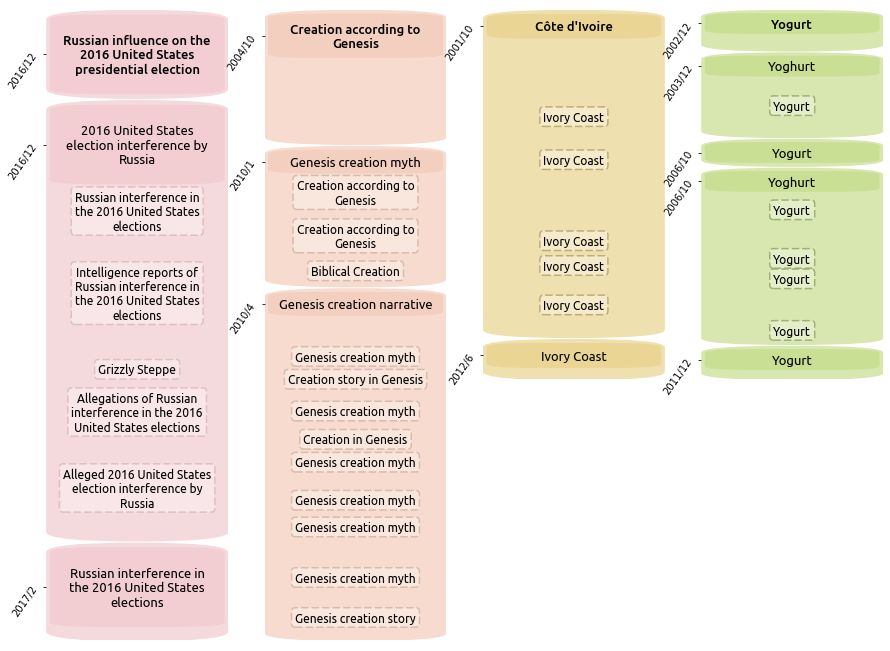

In [713]:
import matplotlib.gridspec as gridspec

cmap = plt.cm.Set3 # 12 colors
cmap = plt.cm.Set2 # 8 colors
colors = cmap.colors
def multiplot(names, heights, **kwargs):
    n = len(names)

    fig = plt.figure(figsize=(3.75*n, 14), constrained_layout=0)
    gs = gridspec.GridSpec(6, n)

    for i, h, name in zip(range(n), heights, names):
        ax = fig.add_subplot(gs[:h, i])
        plot_hist(fig, ax, hists[name], 
                  basecolor=colors[i], # XXX
                  **kwargs)
    return fig

names = ['Russian interference in the 2016 United States elections', 'Genesis creation narrative',
         'Ivory Coast', 'Yogurt']
colors = sns.color_palette('pastel',n_colors=len(names), desat=.75)
colors = sns.husl_palette(n_colors=n, s=.65, l=.83)
#colors = sns.hls_palette(n_colors=n, s=.65, l=.83)
multiplot(names, [5, 5, 3, 3], natural_axes=0, colorize=1,
          inner_lightness=.4,
          ticks=1,
          #bg_lightness=.3, label_lightness=.4,
         );

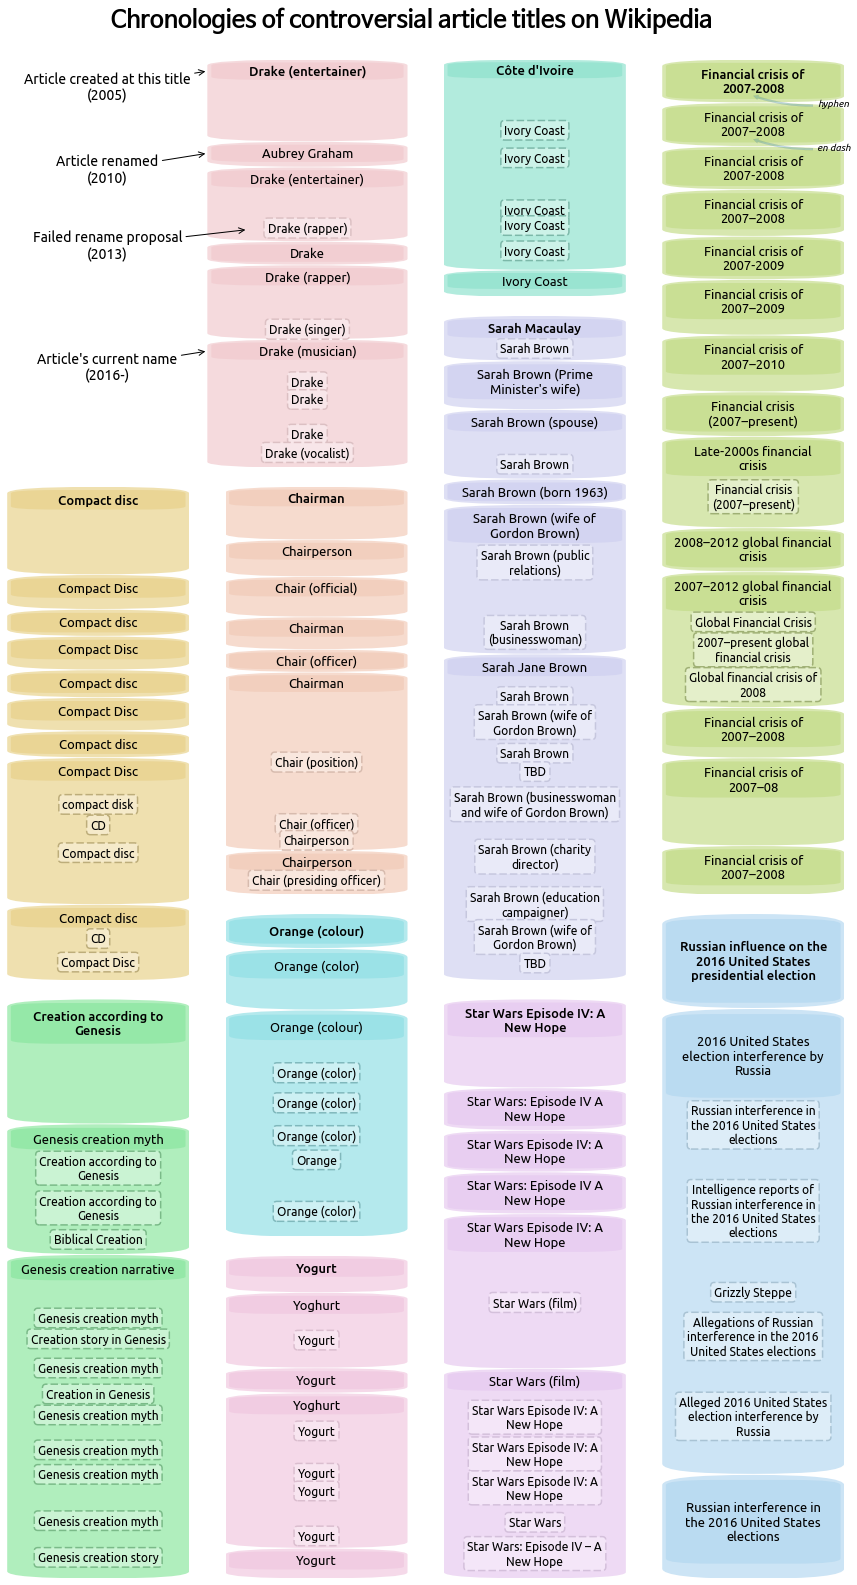

In [802]:
heights = {
    'Financial crisis of 2007–2008': 10, 
    'Ivory Coast': 3, 
    'Compact disc': 6, 
    'Chairperson': 5, 
    'Russian interference in the 2016 United States elections': 8, 
    'Star Wars (film)': 7, 
    'Yogurt': 4,
    'Genesis creation narrative': 7, 
    'Sarah Jane Brown': 8,
    'Drake (musician)': 5,
    'Orange (colour)': 4,
}
colmap = {
    'Financial crisis of 2007–2008': 6,
    'Ivory Coast': 2, 
    'Compact disc': 7,
    'Chairperson': 1, 
    'Russian interference in the 2016 United States elections': 3, 
    'Star Wars (film)': 2, 
    'Yogurt': 4,
    'Genesis creation narrative': 4, 
    'Sarah Jane Brown': 5,
    #'Drake (musician)': 0,
    'Orange (colour)': 0,
}
tall = 1
if tall:
    colmap = {
    'Financial crisis of 2007–2008': 3,
    'Ivory Coast': 2, 
    'Compact disc': 0,
    'Chairperson': 1, 
    'Russian interference in the 2016 United States elections': 3, 
    'Star Wars (film)': 2, 
    'Yogurt': 1,
    'Genesis creation narrative': 0, 
    'Sarah Jane Brown': 2,
    #'Drake (musician)': 0,
    'Orange (colour)': 1,
    }
    rows = 19
else:
    rows = 10
ncols = max(colmap.values())+1
n = len([col for col in colmap.values() if col >= 0]) + 1 # +1 for Drake
cmap = plt.cm.Set3 # 12 colors
#cmap = plt.cm.Set2 # 8 colors
colors = cmap.colors
colors = sns.color_palette('pastel',n_colors=n, desat=.75)
colors = sns.husl_palette(n_colors=n, s=.65, l=.83, h=.01)
assert len(colors) >= n
fc = '#eaf2ff'
fc = '#ffffff'
fig = plt.figure(figsize=(3.75*ncols, 1 + 15*rows/10))
gs = gridspec.GridSpec(rows, ncols, figure=fig, 
                       hspace=.3,
                       #wspace=.22, # for ticks=1
                       #wspace=0.05, hspace=0.05,
                      )

lead = 'Drake (musician)'
h = heights[lead]
colorize=  0
plot_kwargs = dict(colorize=colorize, natural_axes=0,
                   inner_lightness=.4,
                   #bg_lightness=.4, label_lightness=.6, # when colorize=1
                   #ticks=1,
                   #bg_lightness=.3, label_lightness=.4,
                  )
ax = fig.add_subplot(gs[:h, 0:2])
plot_hist(fig, ax, hists[lead], annot=True, 
          basecolor=not colorize and colors[0],
          **plot_kwargs
         )
ax.set_facecolor(fc)

colnext = {i: 0 for i in range(cols)}
colnext[0] = h
colnext[1] = h
i = 0
for _, name in enumerate(sorted(colmap.keys())):
    h = heights[name]
    col = colmap[name]
    if col < 0:
        continue
    x = colnext[col]
    ax = fig.add_subplot(gs[x:x+h, col])
    plot_hist(fig, ax, hists[name], basecolor=not colorize and colors[i+1], **plot_kwargs)
    colnext[col] = x + h
    ax.set_facecolor(fc)
    i += 1
    
fig.suptitle("Chronologies of controversial article titles on Wikipedia", 
             fontsize=24, fontfamily='NanumBarunGothic', fontweight='black',
             y=.905 if tall else .93,
            );

In [726]:
#help(fig.savefig)
for dpi in [60, 80, 100]:
    fig.savefig('viz_colorize_{}.png'.format(dpi), dpi=dpi, bbox_inches='tight')

In [512]:
hists.keys()

dict_keys(['Financial crisis of 2007–2008', 'Ivory Coast', 'Compact disc', 'Chairperson', 'Russian interference in the 2016 United States elections', 'Star Wars (film)', 'Yogurt', 'Genesis creation narrative', 'Sarah Jane Brown'])

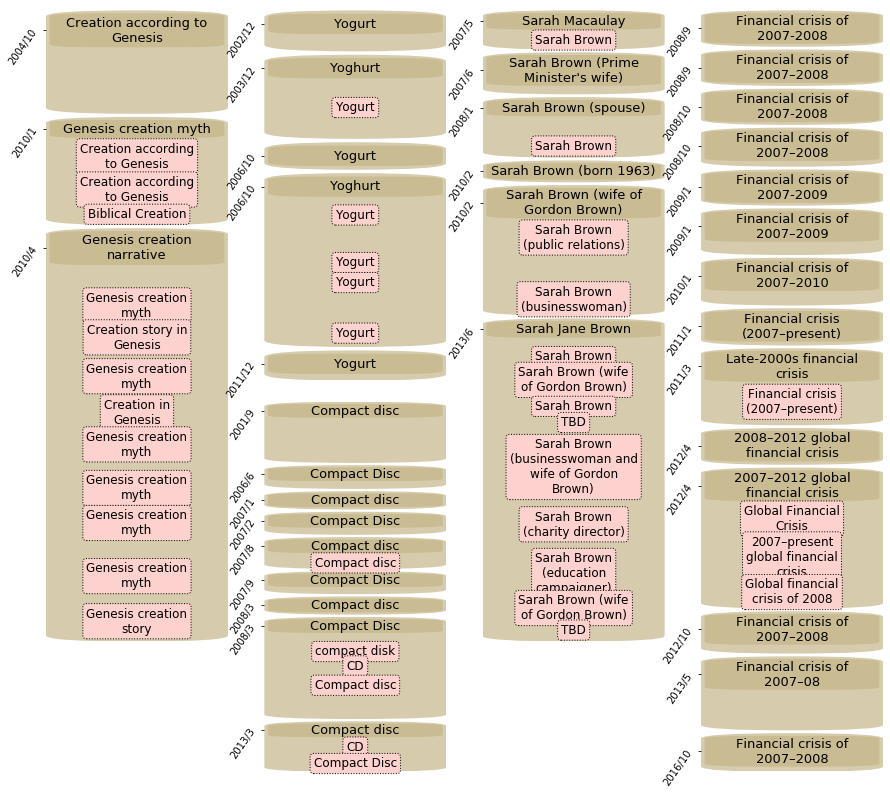

In [481]:


names = ['Genesis creation narrative', 'Yogurt', 'Sarah Jane Brown', 
         'Financial crisis of 2007–2008',
         'Compact disc',]
n = len(names)

fig = plt.figure(figsize=(3.75*4, 14))
gs = gridspec.GridSpec(6, 4)

heights = [5, 3, 5, 6, 4]

for i, h, name in list(zip(range(n), heights, names))[:-1]:
    ax = fig.add_subplot(gs[:h, i])
    plot_hist(fig, ax, hists[name], natural_axes=0, colorize=False)

ax = fig.add_subplot(gs[3:, 1])
plot_hist(fig, ax, hists['Compact disc'], natural_axes=0, colorize=False)

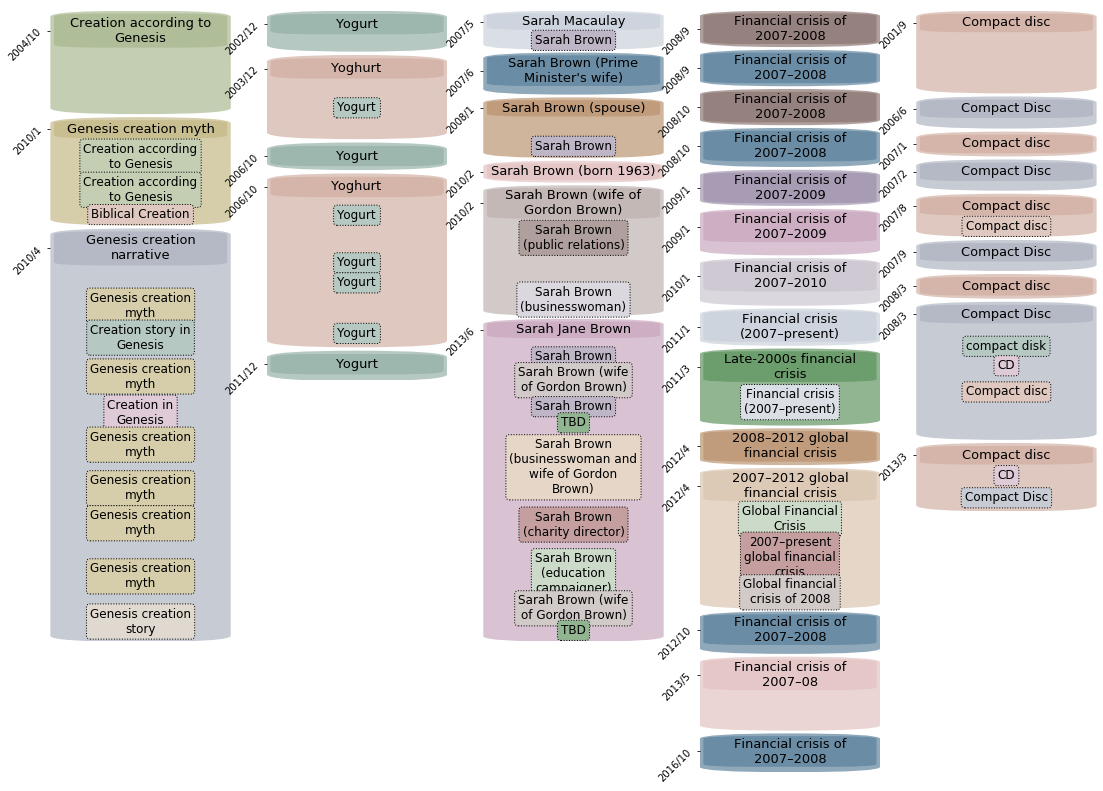

In [429]:
import matplotlib.gridspec as gridspec

names = ['Genesis creation narrative', 'Yogurt', 'Sarah Jane Brown', 
         'Financial crisis of 2007–2008',
         'Compact disc',]
n = len(names)

fig = plt.figure(figsize=(3.75*n, 14))
gs = gridspec.GridSpec(6, 5)

heights = [5, 3, 5, 6, 4]

for i, h, name in zip(range(n), heights, names):
    ax = fig.add_subplot(gs[:h, i])
    plot_hist(fig, ax, hists[name], natural_axes=0, colorize=1)

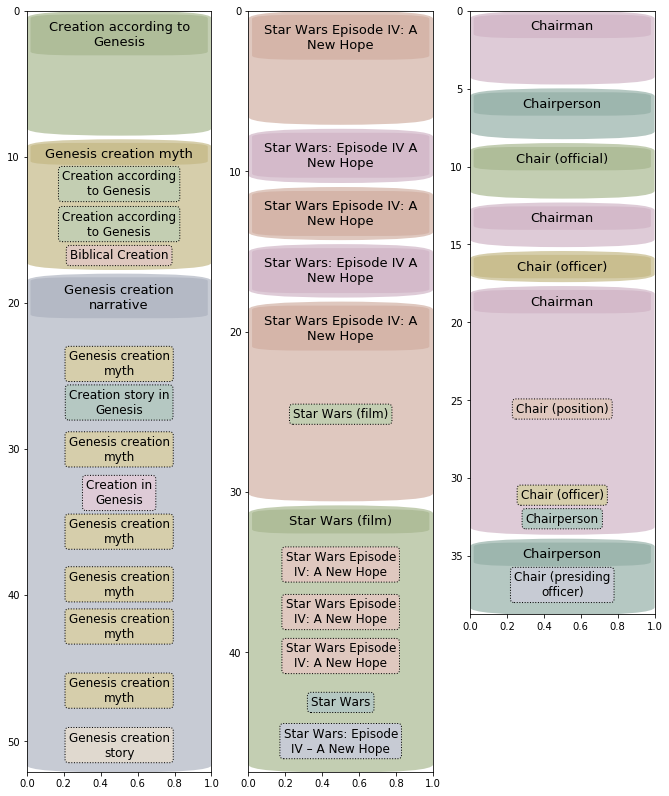

In [431]:
names = ['Genesis creation narrative', 'Star Wars (film)', 'Chairperson',]
n = len(names)

fig = plt.figure(figsize=(3.75*n, 14))
gs = gridspec.GridSpec(5, n)

heights = [5, 5, 4]

for i, h, name in zip(range(n), heights, names):
    ax = fig.add_subplot(gs[:h, i])
    plot_hist(fig, ax, hists[name], natural_axes=1, colorize=1)

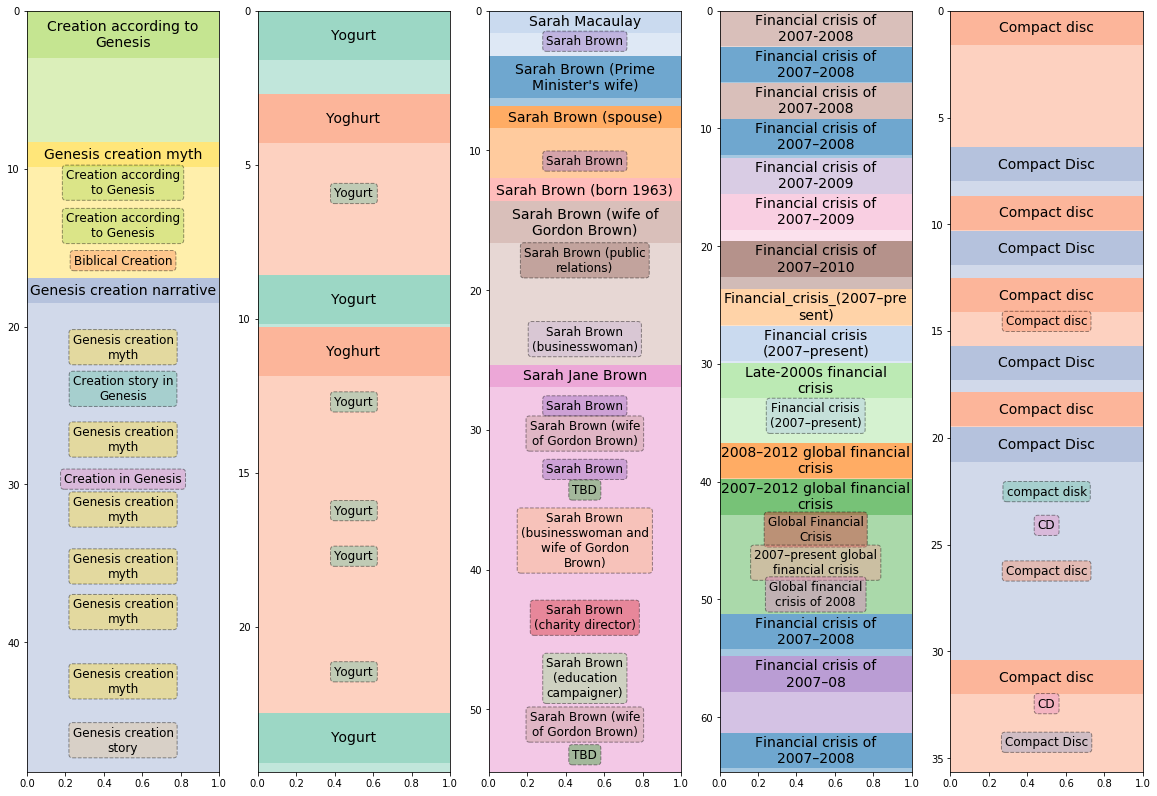

In [329]:
names = ['Genesis creation narrative', 'Yogurt', 'Sarah Jane Brown', 
         'Financial crisis of 2007–2008',
         'Compact disc',]
n = len(names)
fig, axes = plt.subplots(1, n, figsize=(4*n, 14))
for ax, name in zip(axes, names):
    plot_hist(fig, ax, hists[name], natural_axes=True)

In [122]:
hists.keys()

dict_keys(['Financial crisis of 2007–2008', 'Yogurt', 'Compact disc', 'Genesis creation narrative', 'Sarah Jane Brown'])

In [211]:
ax.draw()

TypeError: draw_wrapper() missing 1 required positional argument: 'renderer'

Bbox(x0=-0.3, y0=-0.3, x1=1.3, y1=1.3)
w, h 1.0 1.0
[[-16.21863799 -16.69426049]
 [-15.74074074 -15.95842531]]
Rendering
Bbox(x0=177.82500000000002, y0=197.29600000000002, x1=264.975, y1=235.89600000000002)
w, h 78.75 30.2
[[36.98476703 74.17954378]
 [63.01523297 91.93156733]]


''

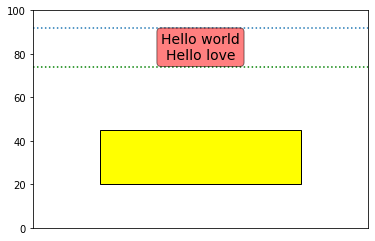

In [346]:
fig, ax = plt.subplots()

X = [0, 25, 75, 100]
Y = [10, 30, 60, 100]
#ax.plot(X, Y)

rect = patches.Rectangle(
    (20, 20),
    60, 25,
    fc='yellow',
    ec='black',
)
ax.add_patch(rect)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

x = ax.text(50,
            90,
            'Hello world\nHello love',
            bbox=dict(boxstyle='round', facecolor='red', alpha=.5),
            ha='center', va='top',
            fontsize=14,
           )

disp_to_data = ax.transData.inverted()
patch = x.get_bbox_patch()
ext = patch.get_extents()
print(ext)
print('w, h', patch.get_width(), patch.get_height())
extent = disp_to_data.transform(ext)
print(extent)
print("Rendering")
fig.canvas.draw()
patch = x.get_bbox_patch()
ext = patch.get_extents()
print(ext)
print('w, h', patch.get_width(), patch.get_height())
extent = disp_to_data.transform(ext)
print(extent)
(x0, y0), (x1, y1) = extent
ax.axhline(y0, ls=':', color='green')
ax.axhline(y1, ls=':')

ax.get_xaxis().set_visible(False)
;

In [173]:
print(type(x))
dir(x)

<class 'matplotlib.text.Text'>


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_axes',
 '_bbox_patch',
 '_cached',
 '_clipon',
 '_clippath',
 '_color',
 '_contains',
 '_draw_bbox',
 '_fontproperties',
 '_get_dist_to_box',
 '_get_layout',
 '_get_multialignment',
 '_get_rendered_text_width',
 '_get_wrap_line_width',
 '_get_wrapped_text',
 '_get_xy_display',
 '_gid',
 '_horizontalalignment',
 '_in_layout',
 '_label',
 '_linespacing',
 '_mouseover',
 '_multialignment',
 '_oid',
 '_path_effects',
 '_picker',
 '_prop_order',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_renderer',
 '_rotation',
 '_rotation_mode',
 '_set_gc_clip',
 '_sketch',
 

In [208]:
patch = x.get_bbox_patch()
dir(patch)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_antialiased',
 '_axes',
 '_bbox_transmuter',
 '_capstyle',
 '_clipon',
 '_clippath',
 '_combined_transform',
 '_contains',
 '_dashes',
 '_dashoffset',
 '_edge_default',
 '_edgecolor',
 '_facecolor',
 '_fill',
 '_gid',
 '_hatch',
 '_hatch_color',
 '_height',
 '_in_layout',
 '_joinstyle',
 '_label',
 '_linestyle',
 '_linewidth',
 '_mouseover',
 '_mutation_aspect',
 '_mutation_scale',
 '_oid',
 '_original_edgecolor',
 '_original_facecolor',
 '_path_effects',
 '_picker',
 '_process_radius',
 '_prop_order',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_set_edgecol

In [178]:
type(patch)

matplotlib.patches.FancyBboxPatch

In [182]:
print(
    patch.get_width(),
    patch.get_height(),
    patch.get_mutation_scale(),
    patch.get_mutation_aspect(),
)

78.75 30.2 14.0 None


In [164]:
trans = patch.get_data_transform()

In [172]:
dir(trans);

In [204]:
patch.get_bbox()

Bbox([[0.0, 0.0], [78.75, 30.2]])

In [209]:
ext = patch.get_extents()
ext

Bbox([[156.90000000000003, 185.496], [244.05, 224.096]])

In [176]:
# display -> data
inv = trans.inverted()
inv.transform(ext)

array([[-4.2 , -4.2 ],
       [82.95, 34.4 ]])

In [206]:
inv2 = ax.transData.inverted()
print(
    inv2.transform(ext),
    #inv2.transform(patch.get_bbox()),
    sep='\n',
)

[[30.73476703 68.75275938]
 [56.76523297 86.50478293]]


In [187]:
e2 = inv2.transform(ext)
(a, b), (c, d) = e2
print(a,b,c,d)

30.734767025089614 68.75275938189846 56.76523297491039 86.504782928624


In [170]:
trans.transform(patch.get_bbox())

array([[161.1  , 189.696],
       [239.85 , 219.896]])

In [177]:
inv.transform(patch.get_bbox())

array([[-161.1  , -189.696],
       [ -82.35 , -159.496]])

In [58]:
# Build df with counts of RMs (from oldmoves templates)
skipped = []
rows = []
no_oldmoves = []
for title in titles:
    try:
        rm = RM(title)
        row = rm.as_row()
        rows.append(row)
    except NoOldMovesTemplateException:
        no_oldmoves.append(title)
    except Exception as e:
        skipped.append(title)
        #raise e

df = pd.DataFrame(rows)
print(
    len(no_oldmoves),
    len(skipped), 
    len(df),
)
df['n'] = df[['arrows', 'bullets']].max(axis=1)
df.head(10)

1 0 420


,arrows,bullets,name,ntitles,titles,n
0,2,2,Talk:Gasoline,0,,2
1,2,2,Talk:Government,0,,2
2,4,4,Talk:The_Holocaust,0,,4
3,2,2,Talk:Moctezuma_II,0,,2
4,2,2,Talk:Perl,0,,2
5,4,4,Talk:United_States_Declaration_of_Independence,0,,4
6,4,4,Talk:Woodstock,0,,4
7,7,7,Talk:Compact_disc,2,Compact Disc↔Compact disc,7
8,2,2,Talk:Elián_González,0,,2
9,7,8,Talk:Star_Wars_(film),0,,8


In [ ]:
# Writing histories (only move histories and count of RMs) to file in semi-human-readable format
top50 = df.sort_values(by='n', ascending=False).head(50)
f = open('top50.txt', 'w')
for row in top50.itertuples():
    #print(row.name[5:])
    if '/' in row.name:
        print("\tSkipping subpage: {}".format(row.name))
        continue
    s = '{} (n={})\n'.format(row.name[5:].replace('_', ' '), row.n)
    s += pprinted_history(row.name) + '\n\n'
    f.write(s)
f.close()

# v Scratch v

In [14]:
title = 'Talk:Sarah Jane Brown'
rm = RM(title)
row = rm.as_row()
row

{'arrows': 16,
 'bullets': 0,
 'name': 'Talk:Sarah Jane Brown',
 'ntitles': 8,
 'titles': "Sarah Brown (wife of Gordon Brown)↔Sarah Jane Brown↔Sarah Brown (businesswoman)↔Sarah Brown (spouse)↔Sarah Brown (Prime Minister's wife)↔Sarah Macaulay↔Sarah Brown (public relations)↔Sarah Brown (Prime Minister's spouse)"}

In [51]:
df[df.arrows != df.bullets].head(5)

,arrows,bullets,name,ntitles,n
9,7,8,Talk:Star_Wars_(film),0,8
14,5,4,Talk:Taiwan,0,5
22,6,7,Talk:Mahatma_Gandhi,0,7
24,12,11,Talk:Madonna,3,12
25,2,3,Talk:Palestinian_territories,2,3


In [65]:
df[df.ntitles > 0].head(5)

,arrows,bullets,name,ntitles,titles,n
7,7,7,Talk:Compact_disc,2,Compact Disc↔Compact disc,7
10,4,4,Talk:Jews,1,Jews,4
20,7,7,Talk:Queen_Victoria,3,Queen Victoria↔Victoria of the United Kingdom↔...,7
24,12,11,Talk:Madonna,3,Madonna (entertainer)↔Madonna (art)↔Madonna,12
25,2,3,Talk:Palestinian_territories,2,Palestinian territories↔Occupied areas of Pale...,3


In [59]:
df.sort_values(by='n', ascending=False).head(50)

,arrows,bullets,name,ntitles,titles,n
338,18,15,Talk:Libyan_Civil_War_(2011),0,,18
233,16,0,Talk:Sarah_Jane_Brown,8,Sarah Brown (wife of Gordon Brown)↔Sarah Jane ...,16
95,16,16,Talk:Genesis_creation_narrative,0,,16
384,15,15,Talk:Western_African_Ebola_virus_epidemic,0,,15
78,0,15,Talk:Ganges,0,,15
337,13,15,Talk:Syrian_Civil_War,0,,15
231,13,4,Talk:Islamic_State_of_Iraq_and_the_Levant,0,,13
24,12,11,Talk:Madonna,3,Madonna (entertainer)↔Madonna (art)↔Madonna,12
26,12,11,Talk:Madonna_(entertainer),3,Madonna (entertainer)↔Madonna (art)↔Madonna,12
98,12,11,Talk:Madonna_(art),3,Madonna (entertainer)↔Madonna (art)↔Madonna,12


In [47]:
no_oldmoves

['Talk:List_of_Doctor_Who_episodes_(1963–1989)']

In [288]:
cm = plt.cm.Set3
dir(cm)

['N',
 '__call__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_i_bad',
 '_i_over',
 '_i_under',
 '_init',
 '_isinit',
 '_lut',
 '_resample',
 '_rgba_bad',
 '_rgba_over',
 '_rgba_under',
 '_set_extremes',
 'colorbar_extend',
 'colors',
 'is_gray',
 'monochrome',
 'name',
 'reversed',
 'set_bad',
 'set_over',
 'set_under']

In [289]:
cm.colors

((0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883))

In [287]:
import numpy as np
plt.cm.Set3(np.linspace(0, 1, 12))

array([[0.55294118, 0.82745098, 0.78039216, 1.        ],
       [1.        , 1.        , 0.70196078, 1.        ],
       [0.74509804, 0.72941176, 0.85490196, 1.        ],
       [0.98431373, 0.50196078, 0.44705882, 1.        ],
       [0.50196078, 0.69411765, 0.82745098, 1.        ],
       [0.99215686, 0.70588235, 0.38431373, 1.        ],
       [0.70196078, 0.87058824, 0.41176471, 1.        ],
       [0.98823529, 0.80392157, 0.89803922, 1.        ],
       [0.85098039, 0.85098039, 0.85098039, 1.        ],
       [0.7372549 , 0.50196078, 0.74117647, 1.        ],
       [0.8       , 0.92156863, 0.77254902, 1.        ],
       [1.        , 0.92941176, 0.43529412, 1.        ]])

In [733]:
fc = hists[fincri]
for row in fc:
    name = row[0]
    if '2007' in name:
        i = name.index('2007')+4
        dash = name[i]
        print(name,
              repr(dash),
              ord(dash),
        )

Financial crisis of 2007-2008 '-' 45
Financial crisis of 2007–2008 '–' 8211
Financial crisis of 2007-2008 '-' 45
Financial crisis of 2007–2008 '–' 8211
Financial crisis of 2007-2009 '-' 45
Financial crisis of 2007–2009 '–' 8211
Financial crisis of 2007–2010 '–' 8211
Financial crisis (2007–present) '–' 8211
Financial crisis (2007–present) '–' 8211
2007–2012 global financial crisis '–' 8211
2007–present global financial crisis '–' 8211
Financial crisis of 2007–2008 '–' 8211
Financial crisis of 2007–08 '–' 8211
Financial crisis of 2007–2008 '–' 8211
